# Carregando o dataset

In [89]:
# Importa bibliotecas necessárias (pandas, numpy, matplotlib, seaborn).

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [90]:
# Lê o arquivo "cardio_train.csv" usando separador ";".
# Exibe as primeiras linhas (head) do dataframe.

data_frame = pd.read_csv("base/cardio_train.csv", sep = ";")
data_frame.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [91]:
# Mostra informações dos tipos de dados e contagem de não-nulos (info).

data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [92]:
# Mostra as dimensões do dataframe.

print(data_frame.shape)

(70000, 13)


In [93]:
# Mostra as colunas do dataframe.

print(data_frame.columns)

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')


# Pré-processamento

In [94]:
# Conta valores nulos por coluna.

data_frame.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Verificando se existem duplicados

In [95]:
# Remove a coluna "id" (identificador único) e conta registros duplicados.

data_frame.drop("id", axis=1 ).duplicated().sum()

np.int64(24)

Verificando a tipagem dos campos

As funções abaixo foram criadas para  informar as medidas de colesterol LDL ou Glicose para converter nas categorias utilizadas no modelo (1- normal, 2 - acima do normal, 3 - alto)

In [96]:
#Funcoes para converter collesterol LDL e Glicose em classificacao normal, acima do normal ou alto

# referencia - https://cardiologistaabc.com.br/index.php/our-destination/colesterol/
#def ldl_to_category(ldl):
#    if ldl < 100:
#        return 1
#    elif ldl < 160:
#        return 2
#    else:
#        return 3

#referencia - https://diabetes.org/about-diabetes/diagnosis
#def glucose_to_category(glucose_mg_dl):
#    if glucose_mg_dl < 100:
#        return 1  # normal
#    elif glucose_mg_dl < 126:
#        return 2  # acima do normal (pré-diabetes)
#    else:
#        return 3  # alto (diabetes)

In [97]:
# Removendo os registros duplicados.

df_sem_duplicadas = data_frame.drop("id", axis=1).drop_duplicates()
df_sem_duplicadas.shape

(69976, 12)

In [98]:
# Filtrar apenas registros válidos para pressão arterial

# ap_hi -> Maior ou igual a 30 e menor ou igual a 280
# ap_lo -> Maior ou igual a 20 e menor ou igual a 200
df_pradonizado = df_sem_duplicadas[
    (df_sem_duplicadas["ap_hi"].between(30, 280)) &
    (df_sem_duplicadas["ap_lo"].between(20, 200))
].copy()

df_pradonizado.shape

(68771, 12)

In [99]:
# Garantindo que o peso nao e uma varialvel escalavel (float)

df_pradonizado["weight"] = df_pradonizado["weight"].astype(int)

# Exploração dos dados

In [100]:
# Garantindo que os campos booleanos serão lidos corretamente

df_pradonizado["smoke"] = df_pradonizado["smoke"].astype(bool)
df_pradonizado["alco"] = df_pradonizado["alco"].astype(bool)
df_pradonizado["active"] = df_pradonizado["active"].astype(bool)
df_pradonizado["cardio"] = df_pradonizado["cardio"].astype(bool)

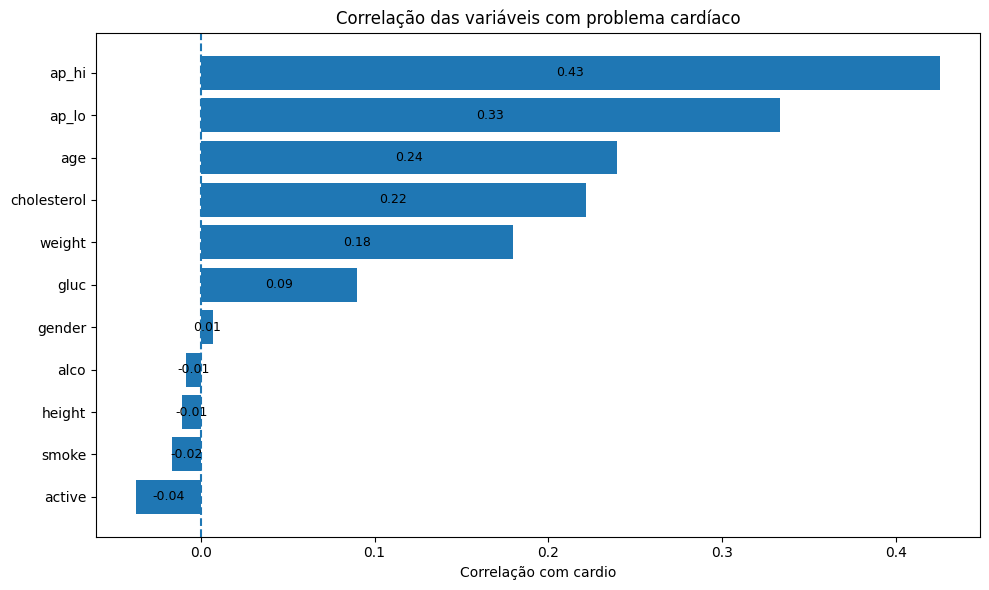

In [101]:
# Gráfico de correlação entre cada coluna e a coluna "cardio"

features = df_pradonizado.drop(columns=["cardio"])

correlacoes = features.corrwith(df_pradonizado["cardio"])
correlacoes = correlacoes.sort_values()

plt.figure(figsize=(10, 6))
bars = plt.barh(correlacoes.index, correlacoes.values)

plt.xlabel("Correlação com cardio")
plt.title("Correlação das variáveis com problema cardíaco")

plt.axvline(0, linestyle="--")

# === RÓTULOS DENTRO DAS BARRAS ===

for bar in bars:
    valor = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    plt.text(
        valor / 2,
        y,
        f"{valor:.2f}",
        va="center",
        ha="center",
        fontsize=9,
        color="black"
    )

plt.tight_layout()
plt.show()

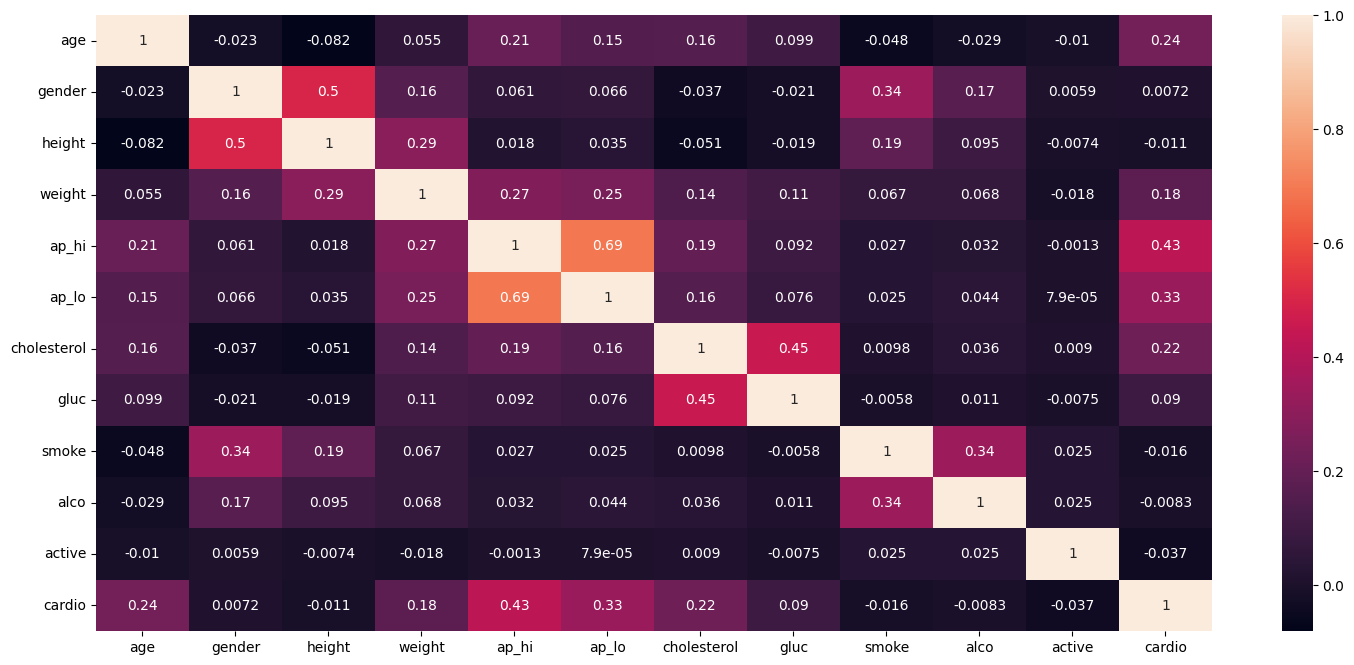

In [102]:
# Coeficientes de correlação entre colunas separadamente

plt.rcParams["figure.figsize"] = (18,8)
ax = sns.heatmap(df_pradonizado.corr(), annot = True)

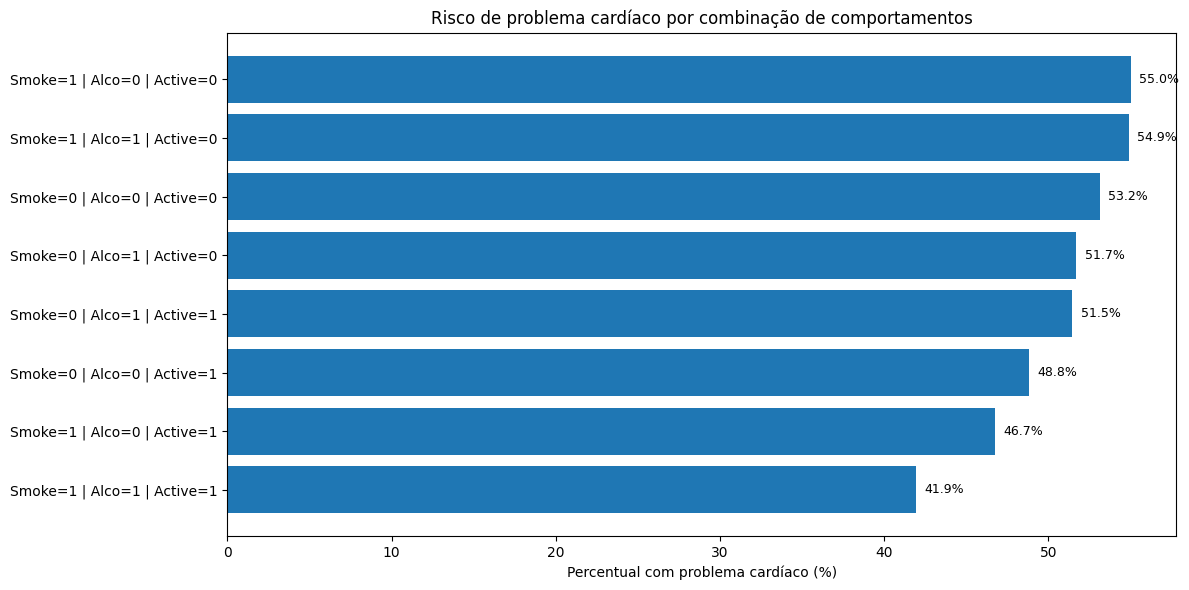

In [103]:
# ==============================
# 1. Preparação dos dados
# ==============================

df = df_pradonizado.copy()

# Garantir que são binárias (0/1)
cols_binarias = ["smoke", "alco", "active", "cardio"]
df[cols_binarias] = df[cols_binarias].astype(int)

# Criar rótulo do perfil comportamental
df["perfil"] = (
    "Smoke=" + df["smoke"].astype(str) +
    " | Alco=" + df["alco"].astype(str) +
    " | Active=" + df["active"].astype(str)
)

# ==============================
# 2. Cálculo do risco por perfil
# ==============================

risco_por_perfil = (
    df
    .groupby("perfil")["cardio"]
    .mean()
    .sort_values()
)

risco_percentual = risco_por_perfil * 100

# ==============================
# 3. Gráfico
# ==============================

plt.figure(figsize=(12, 6))

bars = plt.barh(
    risco_percentual.index,
    risco_percentual.values
)

plt.xlabel("Percentual com problema cardíaco (%)")
plt.title("Risco de problema cardíaco por combinação de comportamentos")

# Rótulos de valor nas barras
for bar in bars:
    valor = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    plt.text(
        valor + 0.5,
        y,
        f"{valor:.1f}%",
        va="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [104]:
# Criando data_frame apenas de resultados onde o paciente apresentou problemas cardiovasculares

data_frame_cardio_true = df_pradonizado[df_pradonizado["cardio"] == True].copy()

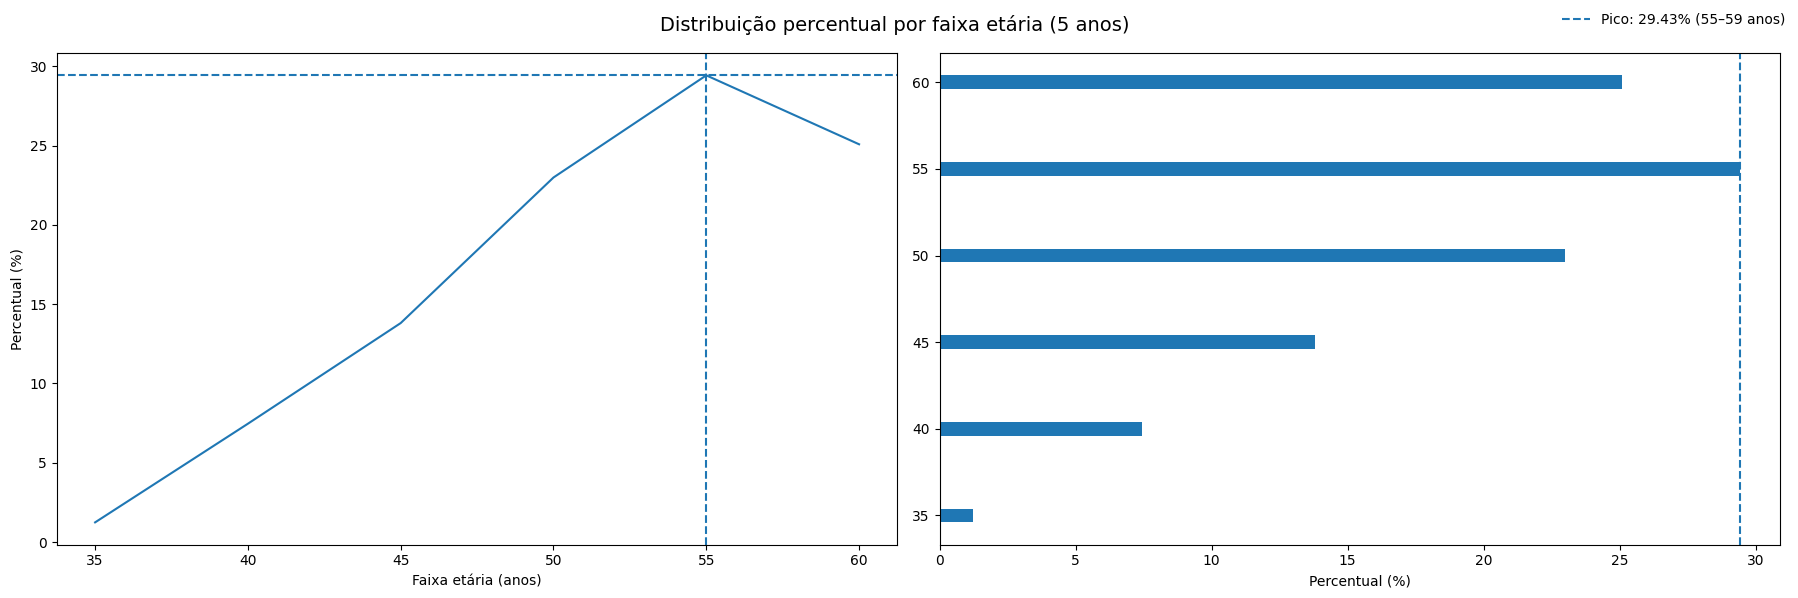

In [105]:

df = data_frame_cardio_true.copy()
df["age"] = (df["age"] // 365).astype(int)
df["age_range_5"] = (df["age"] // 5) * 5

percentual_por_faixa = (
    df["age_range_5"]
    .value_counts(normalize=True)
    .sort_index() * 100
)

maior_percentual = percentual_por_faixa.max()
faixa_pico = percentual_por_faixa.idxmax()
legenda = f"Pico: {maior_percentual:.2f}% ({faixa_pico}–{faixa_pico+4} anos)"

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# === Gráfico de linhas ===
axes[0].plot(percentual_por_faixa.index, percentual_por_faixa.values)

axes[0].set_xlabel("Faixa etária (anos)")
axes[0].set_ylabel("Percentual (%)")

axes[0].axhline(
    y=maior_percentual,
    linestyle="--",
    label = legenda)

axes[0].axvline(x=faixa_pico, linestyle="--")

# === Gráfico de barras horizontais ===
bars = axes[1].barh(percentual_por_faixa.index, percentual_por_faixa.values)

axes[1].set_xlabel("Percentual (%)")
axes[1].axvline(x=maior_percentual,
                linestyle="--")

# === Legenda ===
handles, labels = axes[0].get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    frameon=False
)

fig.suptitle("Distribuição percentual por faixa etária (5 anos)", fontsize=14)
plt.tight_layout()
plt.show()


# Treinamento

Importanto as bibliotecas utilizadas na criação dos modelos

In [106]:
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, roc_curve, accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import shap
import random

#### Separando em treino e teste

In [107]:
x = df_pradonizado.drop(["cardio"], axis = 1)
y = df_pradonizado["cardio"] # Target

In [108]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42 )

In [109]:

# Padronizando os valores

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


#### Teste Modelo 1 : KNeighborsClassifier



Tentando encontrar o melhor K

In [110]:
#Tentando encontrar o melhor K

error = []

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_scaled, y_train)
    pred_i = knn.predict(x_test_scaled)
    error.append(np.mean(pred_i != y_test))



Text(0, 0.5, 'Mean Error')

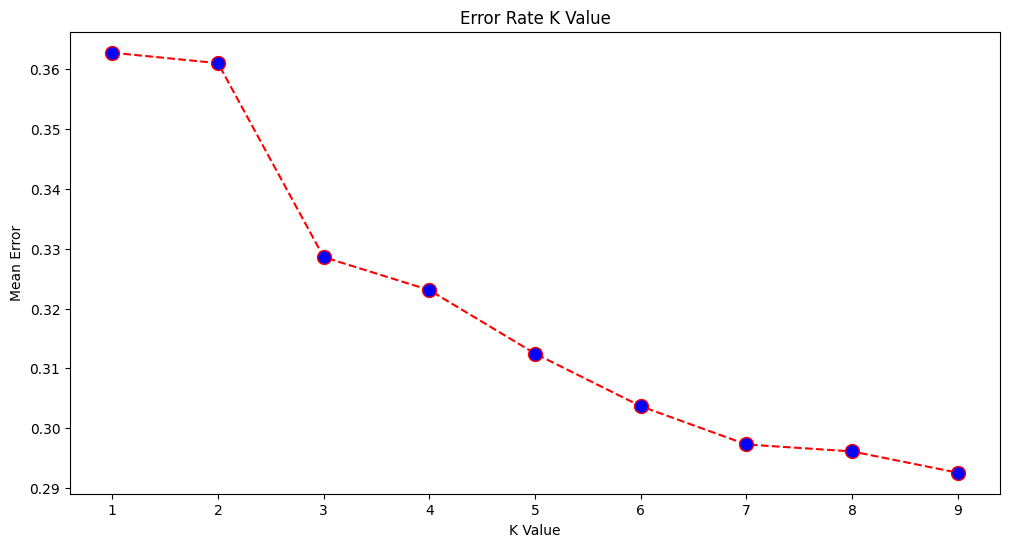

In [111]:
plt.figure(figsize=(12,6))
plt.plot(range(1,10), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title("Error Rate K Value")
plt.xlabel("K Value")
plt.ylabel("Mean Error")

K com menos erros : 7 e 9

In [112]:
best_knn = 7

Criando o Pipeline para executar o StandardScaler e KNN

In [113]:
pipeline_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=best_knn,
        weights="distance"
    ))
])

In [114]:
pipeline_knn.fit(x_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('knn', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",7
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30

In [115]:
y_pred = pipeline_knn.predict(x_test)
y_proba = pipeline_knn.predict_proba(x_test)[:, 1]

In [116]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6934932751726645
[[4883 2063]
 [2153 4656]]
              precision    recall  f1-score   support

       False       0.69      0.70      0.70      6946
        True       0.69      0.68      0.69      6809

    accuracy                           0.69     13755
   macro avg       0.69      0.69      0.69     13755
weighted avg       0.69      0.69      0.69     13755



69% dos casos positivos seriam identificados corretamente os 31% dos doentes positivos  seriam dados como negativo. Isto é ruim clinicamente, temos que aumentar o recall

In [117]:
# Aumentando a probabilidade de ser positivo
# isso vai aumentar o caso de FALSO POSITIVOS, mas clinicamente é mais aceitavel do que FALSO NEGATIVO
y_pred_custom = (y_proba >= 0.30).astype(int)

In [118]:
print(accuracy_score(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

0.6601235914213014
[[3452 3494]
 [1181 5628]]
              precision    recall  f1-score   support

       False       0.75      0.50      0.60      6946
        True       0.62      0.83      0.71      6809

    accuracy                           0.66     13755
   macro avg       0.68      0.66      0.65     13755
weighted avg       0.68      0.66      0.65     13755



#### Teste Modelo 2 : Classificador Naive Bayes Gauseano



In [119]:
x = df_pradonizado.drop(["cardio"], axis = 1)
y = df_pradonizado["cardio"]
print(x)

         age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0      18393       2     168      62    110     80            1     1  False   
1      20228       1     156      85    140     90            3     1  False   
2      18857       1     165      64    130     70            3     1  False   
3      17623       2     169      82    150    100            1     1  False   
4      17474       1     156      56    100     60            1     1  False   
...      ...     ...     ...     ...    ...    ...          ...   ...    ...   
69995  19240       2     168      76    120     80            1     1   True   
69996  22601       1     158     126    140     90            2     2  False   
69997  19066       2     183     105    180     90            3     1  False   
69998  22431       1     163      72    135     80            1     2  False   
69999  20540       1     170      72    120     80            2     1  False   

        alco  active  
0      False    

In [120]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [121]:
modelo_naive = GaussianNB()
modelo_naive.fit(X_train, y_train)
y_pred = modelo_naive.predict(X_test)

In [122]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7144311159578335
[[5651 1284]
 [2644 4176]]
              precision    recall  f1-score   support

       False       0.68      0.81      0.74      6935
        True       0.76      0.61      0.68      6820

    accuracy                           0.71     13755
   macro avg       0.72      0.71      0.71     13755
weighted avg       0.72      0.71      0.71     13755



#### Teste Modelo 3 : Classificador Naive Bayes Bernoulli



In [123]:
x = df_pradonizado.drop(["cardio"], axis = 1)
y = df_pradonizado["cardio"]
print(x)

         age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0      18393       2     168      62    110     80            1     1  False   
1      20228       1     156      85    140     90            3     1  False   
2      18857       1     165      64    130     70            3     1  False   
3      17623       2     169      82    150    100            1     1  False   
4      17474       1     156      56    100     60            1     1  False   
...      ...     ...     ...     ...    ...    ...          ...   ...    ...   
69995  19240       2     168      76    120     80            1     1   True   
69996  22601       1     158     126    140     90            2     2  False   
69997  19066       2     183     105    180     90            3     1  False   
69998  22431       1     163      72    135     80            1     2  False   
69999  20540       1     170      72    120     80            2     1  False   

        alco  active  
0      False    

In [124]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [125]:
modelo_naive = BernoulliNB()
modelo_naive.fit(X_train, y_train)
y_pred = modelo_naive.predict(X_test)

In [126]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5211922937113777

In [127]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5211922937113777
[[5686 1249]
 [5337 1483]]
              precision    recall  f1-score   support

       False       0.52      0.82      0.63      6935
        True       0.54      0.22      0.31      6820

    accuracy                           0.52     13755
   macro avg       0.53      0.52      0.47     13755
weighted avg       0.53      0.52      0.47     13755



#### Teste Modelo 4 : DecisionTreeClassifier



In [128]:
x = df_pradonizado.drop(["cardio"], axis = 1)
y = df_pradonizado["cardio"] # Target

In [129]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [130]:
# Padronizando os valores

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [131]:
###### DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Acurácia: 0.7242457288258815
              precision    recall  f1-score   support

       False       0.69      0.82      0.75      6946
        True       0.78      0.62      0.69      6809

    accuracy                           0.72     13755
   macro avg       0.73      0.72      0.72     13755
weighted avg       0.73      0.72      0.72     13755



O modelo acerta cerca de 72% dos casos. É um desempenho razoável com uma árvore rasa (profundidade 5), indicando que já há padrões capturados sem exagerar na complexidade.

#### Teste Modelo 5 : RandomForestClassifier



In [132]:
x = df_pradonizado.drop(["cardio"], axis = 1)
y = df_pradonizado["cardio"] # Target

In [133]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [134]:
# Padronizando os valores
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [135]:
###### RandomForestClassifier

# Criando o modelo Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100,      # número de árvores
    max_depth=None,        # profundidade máxima (None = cresce até o fim)
    random_state=42,
    n_jobs=-1              # usa todos os núcleos do processador
)

# Treinando o modelo
rf_clf.fit(x_train, y_train)

# Fazendo previsões
y_pred_rf = rf_clf.predict(x_test)

# Avaliando o modelo
print("Acurácia RandomForest:", accuracy_score(y_test, y_pred_rf))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf))

Acurácia RandomForest: 0.7092693565976008

Matriz de Confusão:
 [[5040 1906]
 [2093 4716]]

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.71      0.73      0.72      6946
        True       0.71      0.69      0.70      6809

    accuracy                           0.71     13755
   macro avg       0.71      0.71      0.71     13755
weighted avg       0.71      0.71      0.71     13755



O modelo acerta cerca de 71% dos casos.

#### Teste Modelo 6 : GradientBoostingClassifier



In [136]:
x = df_pradonizado.drop(["cardio"], axis = 1)
y = df_pradonizado["cardio"] # Target

In [137]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [138]:
# Padronizando os valores
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [139]:
# Criando o modelo Gradient Boosting
gb_clf = GradientBoostingClassifier(
    n_estimators=200,     # número de árvores (quanto maior, mais robusto, mas mais lento)
    learning_rate=0.1,    # taxa de aprendizado (menor = mais estável, maior = mais rápido)
    max_depth=3,          # profundidade máxima das árvores
    random_state=42
)

# Treinando o modelo
gb_clf.fit(x_train, y_train)

# Fazendo previsões
y_pred_gb = gb_clf.predict(x_test)

# Avaliando o modelo
print("Acurácia GradientBoosting:", accuracy_score(y_test, y_pred_gb))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_gb))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_gb))

Acurácia GradientBoosting: 0.7301344965467103

Matriz de Confusão:
 [[5384 1562]
 [2150 4659]]

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.71      0.78      0.74      6946
        True       0.75      0.68      0.72      6809

    accuracy                           0.73     13755
   macro avg       0.73      0.73      0.73     13755
weighted avg       0.73      0.73      0.73     13755



Desempenho global de 73%, superior ao RandomForest (71%) e próximo da árvore simples (72%), indicando melhor capacidade de generalização com ajustes moderados.


#### Teste Modelo 7 : Regressão Logística

In [140]:
model_logistic = LogisticRegression(max_iter=1000)

Validando Funcionamento Inicial do Modelo

In [141]:
model_logistic.fit(x_scaled, y_train)
y_prob = model_logistic.predict_proba(x_test_scaled)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)


print(classification_report(y_test, y_pred))
print("Acurácia:",  accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Recall Score:", recall_score(y_test, y_pred))
print("Matriz de Confusão: \n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.70      0.78      0.74      6946
        True       0.75      0.67      0.70      6809

    accuracy                           0.72     13755
   macro avg       0.72      0.72      0.72     13755
weighted avg       0.72      0.72      0.72     13755

Acurácia: 0.7224282079243911
ROC-AUC: 0.78765120366893
Recall Score: 0.6670583051843149
Matriz de Confusão: 
 [[5395 1551]
 [2267 4542]]


Identificando melhor conjunto de parâmetros para o modelo

In [142]:
pipe_logistic_regression = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

# Cada Solver tem um range de penaltys disponíveis. Por conta disso, estão sendo testados três conjuntos de solvers/penaltys diferentes
param_grid = [
    {
        "model__solver": ["lbfgs", "newton-cg", "sag"],
        "model__penalty": ["l2"],
        "model__C": [0.1, 1, 10],
        "model__class_weight": [None, "balanced"]
    },
    {
        "model__solver": ["liblinear"],
        "model__penalty": ["l1", "l2"],
        "model__C": [0.1, 1, 10],
        "model__class_weight": [None, "balanced"]
    },
    {
        "model__solver": ["saga"],
        "model__penalty": ["l1", "l2", "elasticnet"],
        "model__l1_ratio": [0.5],
        "model__C": [0.1, 1, 10],
        "model__class_weight": [None, "balanced"]
    }
]

grid = GridSearchCV(
    estimator=pipe_logistic_regression,
    param_grid=param_grid,
    scoring="recall", # priorizando recall
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Melhor Modelo", best_model)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Melhor Modelo Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    penalty='l2', solver='newton-cg'))])


c:\Users\User\Documents\pos\tech challenge-cardio\treinamento-cardio\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Encontrando o Threshold ideal

In [143]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
best_idx = np.argmax(tpr - fpr)
# Melhor threshold em geral
best_threshold = thresholds[best_idx]
# Melhor threshold para garantir um recall acima de 80%
best_recall_threshold = thresholds[tpr >= 0.80][0]


print("Threshold ideal:", best_threshold)
print("Threshold ideal para garantir um recall acima de 80%:", best_recall_threshold)



Threshold ideal: 0.48445910721289315
Threshold ideal para garantir um recall acima de 80%: 0.3996763656875961


Criando novo pipeline com parâmetros e treshold ideais

In [144]:
pipe_logistic_regression_best = Pipeline([
    ("scaler", StandardScaler()),
    ('model',LogisticRegression(C=1, class_weight='balanced', max_iter=1000,solver='newton-cg'))
])

pipe_logistic_regression_best.fit(x_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work

In [145]:
y_prob = pipe_logistic_regression_best.predict_proba(x_test)[:, 1]

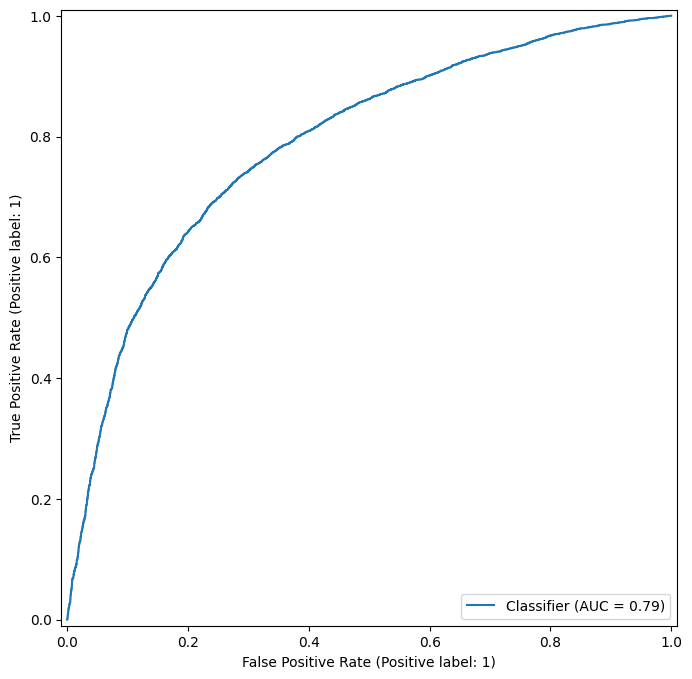

In [146]:
RocCurveDisplay.from_predictions(
    y_test, y_prob / 100
)
plt.show()

A curva ROC-AUC indica que, ao comparar aleatoriamente um paciente doente com um paciente saudável, o modelo atribui uma probabilidade maior ao paciente doente em aproximadamente 79% das vezes.

Testando os valores de threshold identificados anteriormente

In [147]:
y_pred = (y_prob >= best_threshold).astype(int) # utilizando o melhor threshold, o valor do recall está abaixo do aceitável


print(classification_report(y_test, y_pred))
print("Acurácia:",  accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Matriz de Confusão: \n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.72      0.75      0.73      6946
        True       0.73      0.69      0.71      6809

    accuracy                           0.72     13755
   macro avg       0.73      0.72      0.72     13755
weighted avg       0.73      0.72      0.72     13755

Acurácia: 0.7245365321701199
Recall: 0.6949625495667499
Matriz de Confusão: 
 [[5234 1712]
 [2077 4732]]


In [148]:
y_pred = (y_prob >= best_recall_threshold).astype(int) # utilizando o melhor threshold para garantir o recall acima de 80%. Dessa forma, os casos falsos negativos irão diminuir, entretanto teremos menos casos falsos positivos


print(classification_report(y_test, y_pred))
print("Acurácia:",  accuracy_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("Matriz de Confusão: \n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.76      0.61      0.68      6946
        True       0.67      0.81      0.73      6809

    accuracy                           0.71     13755
   macro avg       0.71      0.71      0.70     13755
weighted avg       0.72      0.71      0.70     13755

Acurácia: 0.7057070156306797
Recall Score: 0.8054046115435453
Matriz de Confusão: 
 [[4223 2723]
 [1325 5484]]


Apesar de utilizar um valor abaixo do ideal para o threshold, o modelo perdeu ~2% de acurácia. Entretanto, quando pensamos em um contexto médico/hospitalar, é melhor termos um número de falsos positivos (pacientes que não tem problemas cardiácos, porém foram identificados com tal), do que correr o risco de deixarmos algum paciente doente passar sem identificação.

Utilizando o threshold para priorizar o valor de recall, o modelo apresentou uma acurácia da ~71%, mantendo o valor de recall em ~80%

#### Utilizando Shap para identificar os fatores mais relevantes para a decisão do modelo

In [149]:
X_train_scaled = pipe_logistic_regression_best.named_steps["scaler"].transform(x_train)
X_test_scaled = pipe_logistic_regression_best.named_steps["scaler"].transform(x_test)

feature_names = x.columns

In [150]:
explainer = shap.LinearExplainer(
    pipe_logistic_regression_best.named_steps["model"],
    X_train_scaled,
    feature_names=feature_names
)

In [151]:
shap_values = explainer(X_test_scaled)

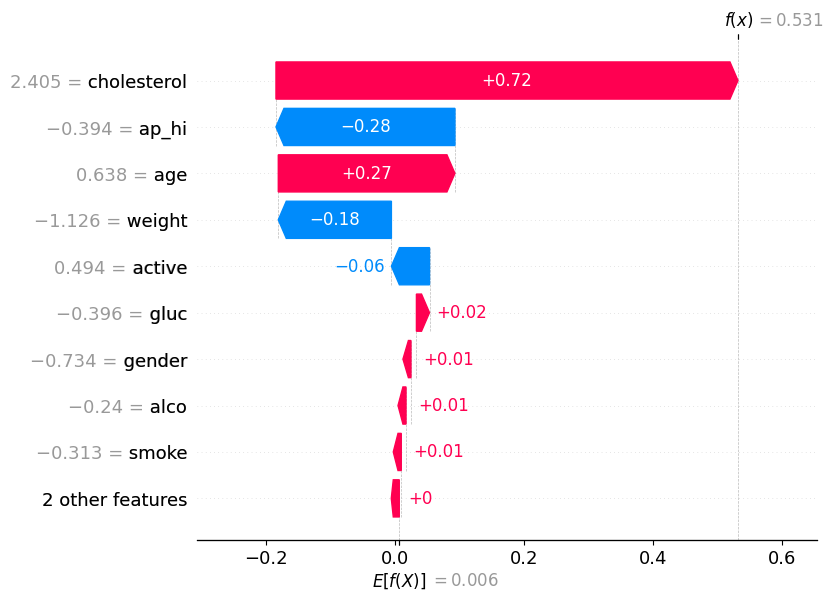

Probabilidade do paciente ter problema cardiáco: 0.6297940115285232


In [152]:
# Selecionando um caso aleatório dentro dos casos separados para teste
i = np.random.randint(0, X_test_scaled.shape[0])

base_log_odds = explainer.expected_value
patient_log_odds = base_log_odds + shap_values[i].values.sum()

prob = 1 / (1 + np.exp(-patient_log_odds))

shap.plots.waterfall(shap_values[i])
print(f"Probabilidade do paciente ter problema cardiáco: {prob}")

# Salvando o melhor modelo para utilizar na API

In [153]:
import joblib

In [154]:
joblib.dump(pipe_logistic_regression_best, 'pipe_logistic_regression.pkl')

['pipe_logistic_regression.pkl']